In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import os

# Define dataset path
extract_path = r"C:\Users\NAMAN JAIN\Downloads\CT-2\ct_scans"
# Define dataset transformation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((64, 64)),  # Resize images
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (-1,1) for Tanh activation
])

# Load dataset
dataset = ImageFolder(root=extract_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Generator
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Hyperparameters
nz = 100  # Latent vector size
ngf = 64  # Generator feature maps
ndf = 64  # Discriminator feature maps
nc = 1    # Number of channels (grayscale)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
generator = Generator(nz, ngf, nc).to(device)
discriminator = Discriminator(nc, ndf).to(device)

# Loss function and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training Loop
num_epochs = 50
real_label = 1.
fake_label = 0.

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        batch_size = real_images.size(0)

        ### Train Discriminator ###
        discriminator.zero_grad()
        real_images = real_images.to(device)
        labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        
        # Forward pass real images
        output = discriminator(real_images).view(-1)
        lossD_real = criterion(output, labels)
        lossD_real.backward()

        # Generate fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = generator(noise)
        labels.fill_(fake_label)

        # Forward pass fake images
        output = discriminator(fake_images.detach()).view(-1)
        lossD_fake = criterion(output, labels)
        lossD_fake.backward()
        
        optimizerD.step()

        ### Train Generator ###
        generator.zero_grad()
        labels.fill_(real_label)  # Fake labels = real for generator loss
        output = discriminator(fake_images).view(-1)
        lossG = criterion(output, labels)
        lossG.backward()
        optimizerG.step()

        # Print progress
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Batch [{i}/{len(dataloader)}] Loss_D: {lossD_real+lossD_fake:.4f} Loss_G: {lossG:.4f}")

    # Save sample images per epoch
    os.makedirs("generated_images", exist_ok=True)
    vutils.save_image(fake_images, f"generated_images/fake_epoch_{epoch+1}.png", normalize=True)


print("Training Complete!")

Epoch [1/50] Batch [0/81] Loss_D: 1.3420 Loss_G: 2.1029
Epoch [2/50] Batch [0/81] Loss_D: 0.0000 Loss_G: 12.0112
Epoch [3/50] Batch [0/81] Loss_D: 0.0097 Loss_G: 6.7383
Epoch [4/50] Batch [0/81] Loss_D: 1.2194 Loss_G: 3.8941
Epoch [5/50] Batch [0/81] Loss_D: 0.3955 Loss_G: 2.7157
Epoch [6/50] Batch [0/81] Loss_D: 0.7482 Loss_G: 1.5534
Epoch [7/50] Batch [0/81] Loss_D: 0.4962 Loss_G: 2.5713
Epoch [8/50] Batch [0/81] Loss_D: 0.8139 Loss_G: 4.0833
Epoch [9/50] Batch [0/81] Loss_D: 0.5544 Loss_G: 2.0382
Epoch [10/50] Batch [0/81] Loss_D: 0.5098 Loss_G: 2.2257
Epoch [11/50] Batch [0/81] Loss_D: 1.0973 Loss_G: 1.0333
Epoch [12/50] Batch [0/81] Loss_D: 0.2783 Loss_G: 3.3712
Epoch [13/50] Batch [0/81] Loss_D: 0.1542 Loss_G: 3.8159
Epoch [14/50] Batch [0/81] Loss_D: 0.5504 Loss_G: 1.7601
Epoch [15/50] Batch [0/81] Loss_D: 0.2182 Loss_G: 2.8536
Epoch [16/50] Batch [0/81] Loss_D: 0.2645 Loss_G: 3.4468
Epoch [17/50] Batch [0/81] Loss_D: 0.2880 Loss_G: 3.9421
Epoch [18/50] Batch [0/81] Loss_D: 0.14

In [7]:
import torch
import os

# Ensure the directory exists
os.makedirs("saved_models", exist_ok=True)

# Save Generator
torch.save(generator.state_dict(), "saved_models/generator.pth")

# Save Discriminator
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

print("✅ Models saved successfully!")


✅ Models saved successfully!


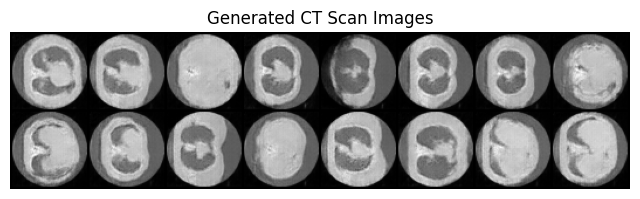

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Load the trained generator
generator.load_state_dict(torch.load("saved_models/generator.pth"))
generator.eval()

# Generate noise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = torch.randn(16, 100, 1, 1, device=device)  # Generate 16 fake images

# Generate images
with torch.no_grad():
    fake_images = generator(noise).cpu()

# Plot images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated CT Scan Images")
plt.imshow(vutils.make_grid(fake_images, padding=2, normalize=True).permute(1, 2, 0))
plt.show()
